In [1]:
%load_ext autoreload
%autoreload 2

import sys
 
# setting path
sys.path.append('../read_data/')
sys.path.append('../')

In [2]:
import glob

import matplotlib.pyplot as plt

In [3]:
from bbox_utils import generate_default_boxes, convert_to_box_form

from dataGenerator import DataGenerator
from classification_loss import SSDLoss

In [4]:
import numpy as np

import tensorflow as tf

In [5]:
import cv2

In [6]:
image_path = '/home/usman/workspace/fisheye_images/train_images/'
label_path = '/home/usman/workspace/fisheye_images/train_labels/'

In [7]:
feature_map_shapes = [38, 19, 10, 5, 3, 1]
aspect_ratios = [
    [1, 2, 0.5],
    [1, 2, 3, 0.5, 0.333],
    [1, 2, 3, 0.5, 0.333],
    [1, 2, 3, 0.5, 0.333],
    [1, 2, 0.5],
    [1, 2, 0.5]
]
number_of_feature_maps = 6

prior_boxes = generate_default_boxes(feature_map_shapes, number_of_feature_maps, aspect_ratios)
boxes = convert_to_box_form(prior_boxes)

2022-09-12 06:39:59.796270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 06:39:59.803079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 06:39:59.803657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 06:39:59.804945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [8]:
# file_names = glob.glob('/home/usman/workspace/fisheye_images/box_2d_annotations/*.txt')

file_names = glob.glob('/home/usman/workspace/fisheye_images/train_labels/*.txt')

list_IDs = []

for file_name in file_names:
    f = open(file_name)
    lines = f.readlines()
    if len(lines) == 0:
        list_IDs.append(file_name)

list_IDs = [f.split('/')[-1].replace('.txt', '') for f in list_IDs]

# list_IDs = [f.split('/')[-1].replace('.txt', '') for f in file_names][:250]

In [9]:
len(list_IDs)

36

In [10]:
dg = DataGenerator(list_IDs, 
                   label_path,
                   image_path, 
                   prior_boxes,
                   boxes,
                  batch_size=16)

In [11]:
loss = SSDLoss()

In [12]:
for d in dg:
    holdout = d
    break

In [13]:
holdout[1][1][0]

<tf.Tensor: shape=(8732, 6), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)>

In [14]:
tf.reduce_sum(holdout[1][1][:, :, 1:], axis = 1)

<tf.Tensor: shape=(16, 5), dtype=float32, numpy=
array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)>

In [15]:
mask = tf.not_equal(holdout[1][0][:, :, :1], tf.constant(0.0))

tf.where(mask)

# tf.reduce_sum(holdout[1][0][:, :, :4], axis = 1)

<tf.Tensor: shape=(0, 3), dtype=int64, numpy=array([], shape=(0, 3), dtype=int64)>

In [16]:
holdout[1][1][1][1383]

<tf.Tensor: shape=(6,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 0.], dtype=float32)>

In [17]:
holdout[1][0][1][1876]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>

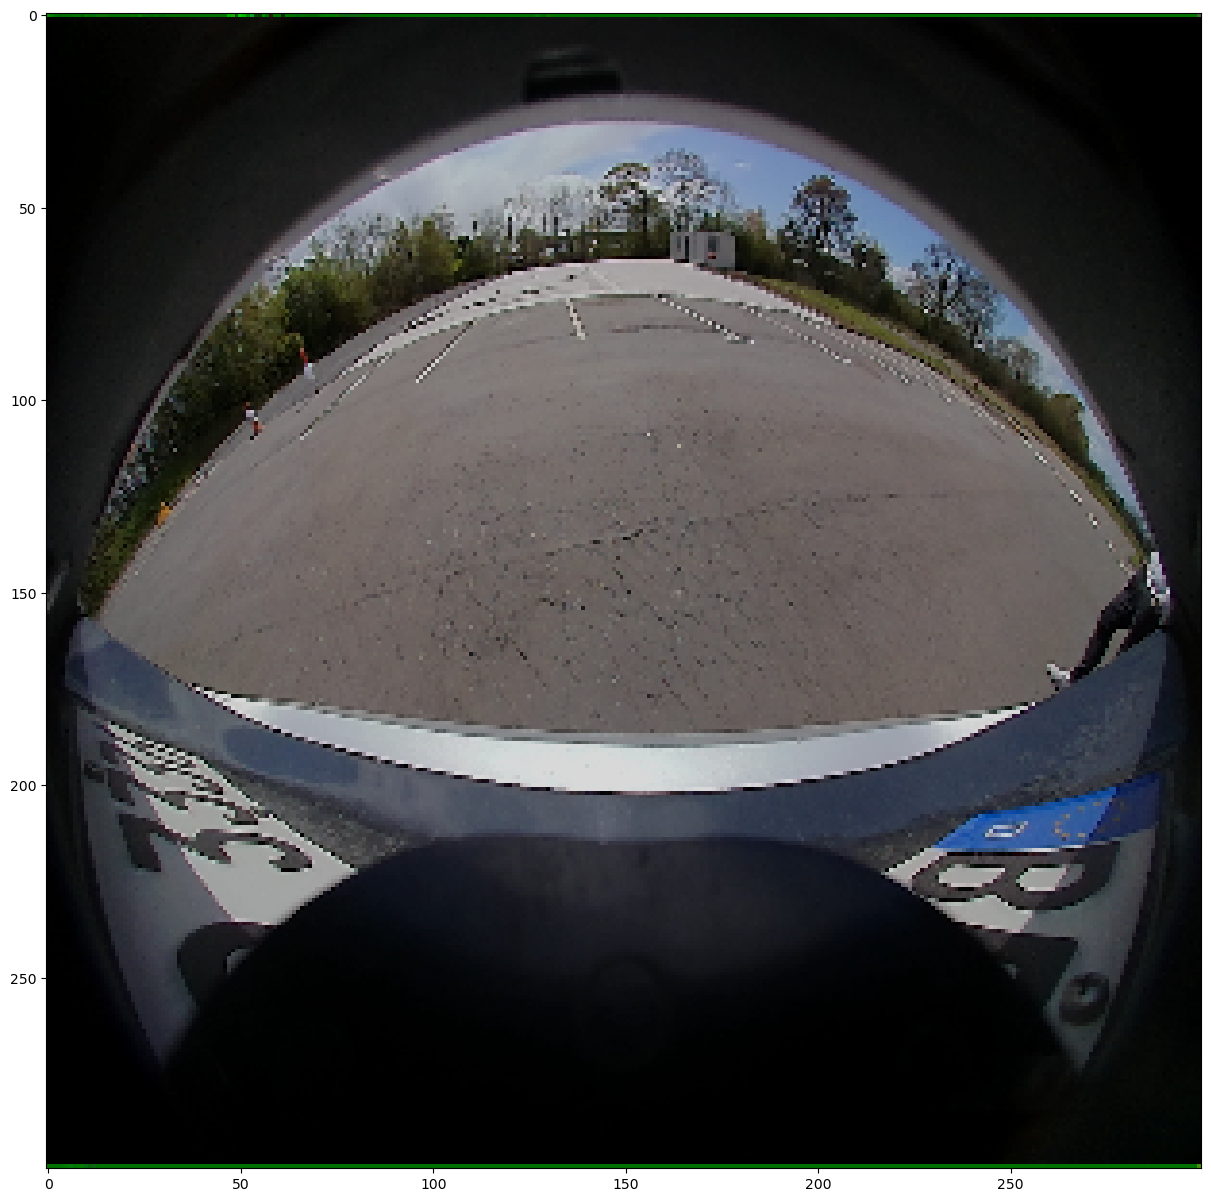

In [18]:
plt.figure(figsize=(15, 15))

plt.imshow(holdout[0][3])

In [19]:
holdout[0].shape

(16, 300, 300, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Conv2D, MaxPool2D, Reshape, Concatenate, MaxPooling2D, ZeroPadding2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

class L2Normalization(Layer):
    """Normalizing different scale features for fusion.
    paper: https://arxiv.org/abs/1506.04579
    inputs:
        feature_map = (batch_size, feature_map_height, feature_map_width, depth)
    outputs:
        normalized_feature_map = (batch_size, feature_map_height, feature_map_width, depth)
    """
    def __init__(self, scale_factor, **kwargs):
        super(L2Normalization, self).__init__(**kwargs)
        self.scale_factor = scale_factor

    def get_config(self):
        config = super(L2Normalization, self).get_config()
        config.update({"scale_factor": self.scale_factor})
        return config

    def build(self, input_shape):
        # Network need to learn scale factor for each channel
        init_scale_factor = tf.fill((input_shape[-1],), float(self.scale_factor))
        self.scale = tf.Variable(init_scale_factor, trainable=True)

    def call(self, inputs):
        return tf.nn.l2_normalize(inputs, axis=-1) * self.scale

In [21]:
SSD = {
    "vgg16": {
        "img_size": 300,
        "feature_map_shapes": feature_map_shapes,
        "aspect_ratios": aspect_ratios,
    },
    "mobilenet_v2": {
        "img_size": 300,
        "feature_map_shapes": [19, 10, 5, 3, 2, 1],
        "aspect_ratios": [[1., 2., 1./2.],
                         [1., 2., 1./2., 3., 1./3.],
                         [1., 2., 1./2., 3., 1./3.],
                         [1., 2., 1./2., 3., 1./3.],
                         [1., 2., 1./2.],
                         [1., 2., 1./2.]],
    }
}

def get_hyper_params(backbone, **kwargs):
    """Generating hyper params in a dynamic way.
    inputs:
        **kwargs = any value could be updated in the hyper_params
    outputs:
        hyper_params = dictionary
    """
    hyper_params = SSD[backbone]
    hyper_params["iou_threshold"] = 0.5
    hyper_params["neg_pos_ratio"] = 3
    hyper_params["loc_loss_alpha"] = 1
    hyper_params["variances"] = [0.1, 0.1, 0.2, 0.2]
    for key, value in kwargs.items():
        if key in hyper_params and value:
            hyper_params[key] = value
    #
    return hyper_params

In [22]:
hyper_params = get_hyper_params('vgg16')
hyper_params['total_labels'] = 6

In [23]:
scale_factor = 20.0
reg_factor = 5e-4
total_labels = hyper_params["total_labels"]
# +1 for ratio 1
len_aspect_ratios = [len(x) + 1 for x in hyper_params["aspect_ratios"]]

In [24]:
len_aspect_ratios = [len(x) + 1 for x in hyper_params["aspect_ratios"]]

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Conv2D, MaxPool2D, Activation

class HeadWrapper(Layer):
    """Merging all feature maps for detections.
    inputs:
        conv4_3 = (batch_size, (layer_shape x aspect_ratios), last_dimension)
            ssd300 conv4_3 shape => (38 x 38 x 4) = 5776
        conv7 = (batch_size, (layer_shape x aspect_ratios), last_dimension)
            ssd300 conv7 shape => (19 x 19 x 6) = 2166
        conv8_2 = (batch_size, (layer_shape x aspect_ratios), last_dimension)
            ssd300 conv8_2 shape => (10 x 10 x 6) = 600
        conv9_2 = (batch_size, (layer_shape x aspect_ratios), last_dimension)
            ssd300 conv9_2 shape => (5 x 5 x 6) = 150
        conv10_2 = (batch_size, (layer_shape x aspect_ratios), last_dimension)
            ssd300 conv10_2 shape => (3 x 3 x 4) = 36
        conv11_2 = (batch_size, (layer_shape x aspect_ratios), last_dimension)
            ssd300 conv11_2 shape => (1 x 1 x 4) = 4
                                           Total = 8732 default box
    outputs:
        merged_head = (batch_size, total_prior_boxes, last_dimension)
    """

    def __init__(self, last_dimension, **kwargs):
        super(HeadWrapper, self).__init__(**kwargs)
        self.last_dimension = last_dimension

    def get_config(self):
        config = super(HeadWrapper, self).get_config()
        config.update({"last_dimension": self.last_dimension})
        return config

    def call(self, inputs):
        last_dimension = self.last_dimension
        batch_size = tf.shape(inputs[0])[0]
        outputs = []
        for conv_layer in inputs:
#             k_1 = conv_layer.shape[1]
#             k_2 = conv_layer.shape[2]
#             k_3 = conv_layer.shape[3]
#             print(k_1, k_2, k_3)
#             print(conv_layer.shape, last_dimension, tf.reshape(conv_layer, (batch_size, (k_1 * k_2 * k_3) // last_dimension, last_dimension)).shape)
#             outputs.append( tf.reshape(conv_layer, (batch_size, (k_1 * k_2 * k_3) // last_dimension, last_dimension)) )
            outputs.append(tf.reshape(conv_layer, (batch_size, -1, last_dimension)))
        #
        return tf.concat(outputs, axis=1)

def get_head_from_outputs(hyper_params, outputs):
    """Generating ssd bbox delta and label heads.
    inputs:
        hyper_params = dictionary
        outputs = list of ssd layers output to be used for prediction
    outputs:
        pred_deltas = merged outputs for bbox delta head
        pred_labels = merged outputs for bbox label head
    """
    total_labels = hyper_params["total_labels"]
    # +1 for ratio 1
    len_aspect_ratios = [len(x) + 1 for x in hyper_params["aspect_ratios"]]
    labels_head = []
    boxes_head = []
    for i, output in enumerate(outputs):
        aspect_ratio = len_aspect_ratios[i]
        labels_head.append(Conv2D(aspect_ratio * total_labels, (3, 3), padding="same", name="{}_conv_label_output".format(i+1))(output))
        boxes_head.append(Conv2D(aspect_ratio * 4, (3, 3), padding="same", name="{}_conv_boxes_output".format(i+1))(output))
    #
    pred_labels = HeadWrapper(total_labels, name="labels_head")(labels_head)
    pred_labels = Activation("softmax", name="conf")(pred_labels)
    #
    pred_deltas = HeadWrapper(4, name="loc")(boxes_head)
    return pred_deltas, pred_labels

In [26]:
l2_reg = l2_regularization = 0.0005
n_classes = 6
n_boxes = [4, 6, 6, 6, 4, 4]

In [27]:
input = Input(shape=(300, 300, 3), name="input")

conv1_1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv1_1')(input)
conv1_2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv1_2')(conv1_1)
pool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool1')(conv1_2)

conv2_1 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv2_1')(pool1)
conv2_2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv2_2')(conv2_1)
pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool2')(conv2_2)

conv3_1 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv3_1')(pool2)
conv3_2 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv3_2')(conv3_1)
conv3_3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv3_3')(conv3_2)
pool3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool3')(conv3_3)

conv4_1 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_1')(pool3)
conv4_2 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_2')(conv4_1)
conv4_3 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_3')(conv4_2)
pool4 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool4')(conv4_3)

conv5_1 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv5_1')(pool4)
conv5_2 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv5_2')(conv5_1)
conv5_3 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv5_3')(conv5_2)
pool5 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same', name='pool5')(conv5_3)

fc6 = Conv2D(1024, (3, 3), dilation_rate=(6, 6), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc6')(pool5)

fc7 = Conv2D(1024, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc7')(fc6)

conv6_1 = Conv2D(256, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_1')(fc7)
conv6_1 = ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv6_padding')(conv6_1)
conv6_2 = Conv2D(512, (3, 3), strides=(2, 2), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_2')(conv6_1)

conv7_1 = Conv2D(128, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_1')(conv6_2)
conv7_1 = ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv7_padding')(conv7_1)
conv7_2 = Conv2D(256, (3, 3), strides=(2, 2), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_2')(conv7_1)

conv8_1 = Conv2D(128, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_1')(conv7_2)
conv8_2 = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_2')(conv8_1)

conv9_1 = Conv2D(128, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_1')(conv8_2)
conv9_2 = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_2')(conv9_1)

# Feed conv4_3 into the L2 normalization layer
conv4_3_norm = L2Normalization(scale_factor=20, name='conv4_3_norm')(conv4_3)

### Build the convolutional predictor layers on top of the base network

# We precidt `n_classes` confidence values for each box, hence the confidence predictors have depth `n_boxes * n_classes`
# Output shape of the confidence layers: `(batch, height, width, n_boxes * n_classes)`
conv4_3_norm_mbox_conf = Conv2D(n_boxes[0] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_3_norm_mbox_conf')(conv4_3_norm)
fc7_mbox_conf = Conv2D(n_boxes[1] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc7_mbox_conf')(fc7)
conv6_2_mbox_conf = Conv2D(n_boxes[2] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_2_mbox_conf')(conv6_2)
conv7_2_mbox_conf = Conv2D(n_boxes[3] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_2_mbox_conf')(conv7_2)
conv8_2_mbox_conf = Conv2D(n_boxes[4] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_2_mbox_conf')(conv8_2)
conv9_2_mbox_conf = Conv2D(n_boxes[5] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_2_mbox_conf')(conv9_2)
# We predict 4 box coordinates for each box, hence the localization predictors have depth `n_boxes * 4`
# Output shape of the localization layers: `(batch, height, width, n_boxes * 4)`
conv4_3_norm_mbox_loc = Conv2D(n_boxes[0] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_3_norm_mbox_loc')(conv4_3_norm)
fc7_mbox_loc = Conv2D(n_boxes[1] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc7_mbox_loc')(fc7)
conv6_2_mbox_loc = Conv2D(n_boxes[2] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_2_mbox_loc')(conv6_2)
conv7_2_mbox_loc = Conv2D(n_boxes[3] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_2_mbox_loc')(conv7_2)
conv8_2_mbox_loc = Conv2D(n_boxes[4] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_2_mbox_loc')(conv8_2)
conv9_2_mbox_loc = Conv2D(n_boxes[5] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_2_mbox_loc')(conv9_2)


In [28]:
conv4_3_norm_mbox_loc

<KerasTensor: shape=(None, 38, 38, 16) dtype=float32 (created by layer 'conv4_3_norm_mbox_loc')>

In [29]:
Reshape((-1, 4), name='conv4_3_norm_mbox_conf_reshape')(conv4_3_norm_mbox_loc)

<KerasTensor: shape=(None, 5776, 4) dtype=float32 (created by layer 'conv4_3_norm_mbox_conf_reshape')>

In [30]:
conv4_3_norm_mbox_conf_reshape = Reshape((-1, n_classes), name='conv4_3_norm_mbox_conf_reshape')(conv4_3_norm_mbox_conf)
fc7_mbox_conf_reshape = Reshape((-1, n_classes), name='fc7_mbox_conf_reshape')(fc7_mbox_conf)
conv6_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv6_2_mbox_conf_reshape')(conv6_2_mbox_conf)
conv7_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv7_2_mbox_conf_reshape')(conv7_2_mbox_conf)
conv8_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv8_2_mbox_conf_reshape')(conv8_2_mbox_conf)
conv9_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv9_2_mbox_conf_reshape')(conv9_2_mbox_conf)

In [31]:
conv4_3_norm_mbox_loc_reshape = Reshape((-1, 4), name='conv4_3_norm_mbox_loc_reshape')(conv4_3_norm_mbox_loc)
fc7_mbox_loc_reshape = Reshape((-1, 4), name='fc7_mbox_loc_reshape')(fc7_mbox_loc)
conv6_2_mbox_loc_reshape = Reshape((-1, 4), name='conv6_2_mbox_loc_reshape')(conv6_2_mbox_loc)
conv7_2_mbox_loc_reshape = Reshape((-1, 4), name='conv7_2_mbox_loc_reshape')(conv7_2_mbox_loc)
conv8_2_mbox_loc_reshape = Reshape((-1, 4), name='conv8_2_mbox_loc_reshape')(conv8_2_mbox_loc)
conv9_2_mbox_loc_reshape = Reshape((-1, 4), name='conv9_2_mbox_loc_reshape')(conv9_2_mbox_loc)

In [32]:
mbox_conf = Concatenate(axis=1, name='mbox_conf')([conv4_3_norm_mbox_conf_reshape,
                                                       fc7_mbox_conf_reshape,
                                                       conv6_2_mbox_conf_reshape,
                                                       conv7_2_mbox_conf_reshape,
                                                       conv8_2_mbox_conf_reshape,
                                                       conv9_2_mbox_conf_reshape])

mbox_loc = Concatenate(axis=1, name='mbox_loc')([conv4_3_norm_mbox_loc_reshape,
                                                     fc7_mbox_loc_reshape,
                                                     conv6_2_mbox_loc_reshape,
                                                     conv7_2_mbox_loc_reshape,
                                                     conv8_2_mbox_loc_reshape,
                                                     conv9_2_mbox_loc_reshape])

In [33]:
mbox_conf_softmax = Activation('softmax', name='mbox_conf_softmax')(mbox_conf)

In [34]:
mbox_conf_softmax

<KerasTensor: shape=(None, 8732, 6) dtype=float32 (created by layer 'mbox_conf_softmax')>

In [35]:
loss = SSDLoss()

In [36]:
ssd_VGG16 = Model(inputs=input, outputs=[mbox_loc, mbox_conf_softmax])

In [ ]:
i = 0
for d in dg:
    holdout = d
    pred = ssd_VGG16.predict(holdout[0])
    loc_los = loss.localization_loss(holdout[1][0], pred[0])
    conf_loss = loss.confidence_loss(holdout[1][1], pred[1])
    print(tf.reduce_sum(holdout[1][1][:, :, 1:], axis = 1))
    print( 'loc_los: ', tf.reduce_sum(loc_los, axis = 1) )
    print( 'conf_loss: ', tf.reduce_sum(conf_loss, axis = 1) )
    print('-'*30)
    i+=1
    if i > 10:
        break

In [ ]:
# from keras.utils.vis_utils import plot_model

In [ ]:
# plot_model(ssd_VGG16, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [37]:
ssd_VGG16.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1 (Conv2D)               (None, 300, 300, 64  1792        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 conv1_2 (Conv2D)               (None, 300, 300, 64  36928       ['conv1_1[0][0]']                
                                )                                                             

                                                                                                  
 conv8_2_mbox_conf (Conv2D)     (None, 3, 3, 24)     55320       ['conv8_2[0][0]']                
                                                                                                  
 conv9_2_mbox_conf (Conv2D)     (None, 1, 1, 24)     55320       ['conv9_2[0][0]']                
                                                                                                  
 conv4_3_norm_mbox_loc (Conv2D)  (None, 38, 38, 16)  73744       ['conv4_3_norm[0][0]']           
                                                                                                  
 fc7_mbox_loc (Conv2D)          (None, 19, 19, 24)   221208      ['fc7[0][0]']                    
                                                                                                  
 conv6_2_mbox_loc (Conv2D)      (None, 10, 10, 24)   110616      ['conv6_2[0][0]']                
          

In [ ]:
ssd_VGG16.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001), loss=[loss.localization_loss, loss.confidence_loss])

In [ ]:
ssd_VGG16.fit(dg, epochs = 100)

In [ ]:
# ssd_VGG16.save('/Users/usmanr/workspace/SSDLoss/models/ssd_1000_img')

In [ ]:
pred = ssd_VGG16.predict(holdout[0])

In [ ]:
conf_loss = pred[1]

In [ ]:
conf_loss[2].shape

In [ ]:
image = holdout[0][0]

In [ ]:
image_width = image_height = 300

plt.figure(figsize=(15, 15))

start_x, start_y, end_x, end_y = boxes[156, :].numpy()
    
start_x, start_y, end_x, end_y = int(start_x * image_width), int(start_y * image_height), int(end_x * image_width), int(end_y * image_height)

image = cv2.rectangle(image, [start_x, start_y], [end_x, end_y], (255, 0, 0), thickness = 1)

plt.imshow(image)

In [ ]:
boxes_with_highest_conf = []

for i, conf in enumerate(conf_loss[0]):
    c = conf
    boxes_with_highest_conf.append([ np.max(c), np.argmax(c) + 1, i])

boxes_with_highest_conf.sort(key=lambda x: x[0], reverse=True)

In [ ]:
boxes_with_highest_conf[:10]

In [ ]:
print(conf_loss[0][0])
print(conf_loss[0][2])
print(conf_loss[0][3])
print(conf_loss[0][4])
print(conf_loss[0][5])
print(conf_loss[0][159])

In [ ]:
input = Input(shape=(300, 300, 3), name="input")
# conv1 block
conv1_1 = Conv2D(64, (3, 3), padding="same", activation="relu", kernel_initializer="glorot_normal", kernel_regularizer=l2(reg_factor), name="conv1_1")(input)
conv1_2 = Conv2D(64, (3, 3), padding="same", activation="relu", kernel_initializer="glorot_normal", kernel_regularizer=l2(reg_factor), name="conv1_2")(conv1_1)
pool1 = MaxPool2D((2, 2), strides=(2, 2), padding="same", name="pool1")(conv1_2)
# conv2 block
conv2_1 = Conv2D(128, (3, 3), padding="same", activation="relu", kernel_initializer="glorot_normal", kernel_regularizer=l2(reg_factor), name="conv2_1")(pool1)
conv2_2 = Conv2D(128, (3, 3), padding="same", activation="relu", kernel_initializer="glorot_normal", kernel_regularizer=l2(reg_factor), name="conv2_2")(conv2_1)
pool2 = MaxPool2D((2, 2), strides=(2, 2), padding="same", name="pool2")(conv2_2)
# conv3 block
conv3_1 = Conv2D(256, (3, 3), padding="same", activation="relu", kernel_initializer="glorot_normal", kernel_regularizer=l2(reg_factor), name="conv3_1")(pool2)
conv3_2 = Conv2D(256, (3, 3), padding="same", activation="relu", kernel_initializer="glorot_normal", kernel_regularizer=l2(reg_factor), name="conv3_2")(conv3_1)
conv3_3 = Conv2D(256, (3, 3), padding="same", activation="relu", kernel_initializer="glorot_normal", kernel_regularizer=l2(reg_factor), name="conv3_3")(conv3_2)
pool3 = MaxPool2D((2, 2), strides=(2, 2), padding="same", name="pool3")(conv3_3)
# conv4 block
conv4_1 = Conv2D(512, (3, 3), padding="same", activation="relu", kernel_initializer="glorot_normal", kernel_regularizer=l2(reg_factor), name="conv4_1")(pool3)
conv4_2 = Conv2D(512, (3, 3), padding="same", activation="relu", kernel_initializer="glorot_normal", kernel_regularizer=l2(reg_factor), name="conv4_2")(conv4_1)
conv4_3 = Conv2D(512, (3, 3), padding="same", activation="relu", kernel_initializer="glorot_normal", kernel_regularizer=l2(reg_factor), name="conv4_3")(conv4_2)
pool4 = MaxPool2D((2, 2), strides=(2, 2), padding="same", name="pool4")(conv4_3)
# conv5 block
conv5_1 = Conv2D(512, (3, 3), padding="same", activation="relu", kernel_initializer="glorot_normal", kernel_regularizer=l2(reg_factor), name="conv5_1")(pool4)
conv5_2 = Conv2D(512, (3, 3), padding="same", activation="relu", kernel_initializer="glorot_normal", kernel_regularizer=l2(reg_factor), name="conv5_2")(conv5_1)
conv5_3 = Conv2D(512, (3, 3), padding="same", activation="relu", kernel_initializer="glorot_normal", kernel_regularizer=l2(reg_factor), name="conv5_3")(conv5_2)
pool5 = MaxPool2D((3, 3), strides=(1, 1), padding="same", name="pool5")(conv5_3)
# conv6 and conv7 converted from fc6 and fc7 and remove dropouts
# These layers coming from modified vgg16 model
# https://gist.github.com/weiliu89/2ed6e13bfd5b57cf81d6
conv6 = Conv2D(1024, (3, 3), dilation_rate=6, padding="same", activation="relu", kernel_initializer="glorot_normal", kernel_regularizer=l2(reg_factor), name="conv6")(pool5)
conv7 = Conv2D(1024, (1, 1), strides=(1, 1), padding="same", activation="relu", kernel_initializer="glorot_normal", kernel_regularizer=l2(reg_factor), name="conv7")(conv6)
############################ Extra Feature Layers Start ############################
# conv8 block <=> conv6 block in paper caffe implementation
conv8_1 = Conv2D(256, (1, 1), strides=(1, 1), padding="valid", activation="relu", kernel_initializer="glorot_normal", kernel_regularizer=l2(reg_factor), name="conv8_1")(conv7)
conv8_2 = Conv2D(512, (3, 3), strides=(2, 2), padding="same", activation="relu", kernel_initializer="glorot_normal", kernel_regularizer=l2(reg_factor), name="conv8_2")(conv8_1)
# conv9 block <=> conv7 block in paper caffe implementation
conv9_1 = Conv2D(128, (1, 1), strides=(1, 1), padding="valid", activation="relu", kernel_initializer="glorot_normal", kernel_regularizer=l2(reg_factor), name="conv9_1")(conv8_2)
conv9_2 = Conv2D(256, (3, 3), strides=(2, 2), padding="same", activation="relu", kernel_initializer="glorot_normal", kernel_regularizer=l2(reg_factor), name="conv9_2")(conv9_1)
# conv10 block <=> conv8 block in paper caffe implementation
conv10_1 = Conv2D(128, (1, 1), strides=(1, 1), padding="valid", activation="relu", kernel_initializer="glorot_normal", kernel_regularizer=l2(reg_factor), name="conv10_1")(conv9_2)
conv10_2 = Conv2D(256, (3, 3), strides=(1, 1), padding="valid", activation="relu", kernel_initializer="glorot_normal", kernel_regularizer=l2(reg_factor), name="conv10_2")(conv10_1)
# conv11 block <=> conv9 block in paper caffe implementation
conv11_1 = Conv2D(128, (1, 1), strides=(1, 1), padding="valid", activation="relu", kernel_initializer="glorot_normal", kernel_regularizer=l2(reg_factor), name="conv11_1")(conv10_2)
conv11_2 = Conv2D(256, (3, 3), strides=(1, 1), padding="valid", activation="relu", kernel_initializer="glorot_normal", kernel_regularizer=l2(reg_factor), name="conv11_2")(conv11_1)
############################ Extra Feature Layers End ############################
# l2 normalization for each location in the feature map
conv4_3_norm = L2Normalization(scale_factor)(conv4_3)
#
pred_deltas, pred_labels = get_head_from_outputs(hyper_params, [conv4_3_norm, conv7, conv8_2, conv9_2, conv10_2, conv11_2])

In [ ]:
ssd_VGG16 = Model(inputs=input, outputs=[pred_deltas, pred_labels])

In [ ]:
ssd_VGG16.summary()

In [ ]:
loss = SSDLoss()

In [ ]:
ssd_VGG16.compile(optimizer="Adam", loss=[loss.localization_loss, loss.confidence_loss])

In [ ]:
ssd_VGG16.fit(dg)

In [ ]:
pred = ssd_VGG16.predict(holdout[0])

In [ ]:
loc_loss = loss.localization_loss(holdout[1][0], pred[0])

In [ ]:
tf.reduce_sum(loc_loss, axis = 1)

In [ ]:
conf_loss = loss.confidence_loss(holdout[1][1], pred[1])

In [ ]:
tf.reduce_sum(conf_loss, axis = 1)

In [ ]:
ssd_VGG16.fit(dg)

In [ ]:
import numpy as np

In [ ]:
y_true = np.random.random(size=(8,8732,4)).astype(np.float32)
pos_cond = np.random.randint(0, 2, size=(8,8732,1)).astype(np.float32)
y_true = tf.concat([y_true, pos_cond ], axis = 2)
y_pred = np.random.random(size=(8,8732,4)).astype(np.float32)

In [ ]:
loss = SSDLoss()

In [ ]:
loss.localization_loss(y_true, y_pred)

In [ ]:
t1 = np.random.random(size=(8,38,38,4, 4))
t2 = np.random.random(size=(8,19,19,6,4))
t3 = np.random.random(size=(8,10,10,6,4))
t4 = np.random.random(size=(8,5,5,6,4))
t5 = np.random.random(size=(8,3,3,4,4))
t6 = np.random.random(size=(8,1,1,4,4))

output = []

for t in [t1, t2, t3, t4, t5, t6]:
    output.append(tf.reshape(t, (8, -1, 4)))

# tf.reshape(t5, [8, -1, 4])

In [ ]:
38 * 38 * 4 + 19 * 19 * 6 + 10 * 10 * 6 + 5 * 5 * 6 + 3 * 3 * 4 + 1 * 1 * 4

In [ ]:
tf.concat(output, axis = 1)

In [ ]:
t